# League of Legends Item Balancing
### Capstone Project 1: Data Storytelling

The overarching question: How would a developer for this game know when they need to change an item?

This notebook walks through the data, some easy trends, and poses questions for analysis.

### Data

Champions: This is information on the playable characters in the game. 

Items: This is information on the purchasable items in the game.

Match Data: This is information on games themselves, including played champions, final items bought, when the final items were bought, etc. 

In [1]:
import math
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

#### Matches

In [2]:
matches_df = pd.read_csv('..\\data\\match_data_2.csv', encoding='utf-8', index_col=0)
matches_df.head(1)

,championId,highestAchievedSeasonTier,item0_time,item1_time,item2_time,item3_time,item4_time,item5_time,item6_time,masteries,...,timeline.participantId,timeline.role,timeline.xpDiffPerMinDeltas.0-10,timeline.xpDiffPerMinDeltas.10-20,timeline.xpDiffPerMinDeltas.20-30,timeline.xpDiffPerMinDeltas.30-end,timeline.xpPerMinDeltas.0-10,timeline.xpPerMinDeltas.10-20,timeline.xpPerMinDeltas.20-30,timeline.xpPerMinDeltas.30-end
0,103,SILVER,1442408.0,1317001.0,1097684.0,NaN,1955521.0,1859933.0,NaN,NaN,...,1,DUO_CARRY,-19.3,-24.55,-50.25,NaN,332.5,458.8,424.8,NaN


Distribution of item purchase times as a function of item slot. Items naturally go into slots sequentially (except for slot 6), but players can manually swap the slots. I'm unsure if that influences this data.

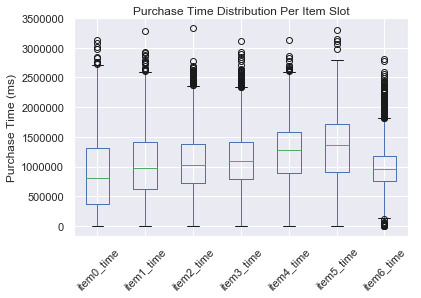

In [3]:
matches_df.boxplot(column=['item0_time', 'item1_time', 'item2_time', 'item3_time',
                           'item4_time', 'item5_time', 'item6_time'], return_type='axes', rot=45)
plt.title('Purchase Time Distribution Per Item Slot')
plt.ylabel('Purchase Time (ms)')

In [4]:
print("The number of matches in the table is " + str(len(matches_df)/10) +
      ", and each match has 10 players/champions, so there are " + str(len(matches_df)) +
      " rows in the dataframe.")

The number of matches in the table is 925, and each match has 10 players/champions, so there are 9250 rows in the dataframe.


Here is a sample of the items bought by 5 players in a game. 0s indicate no item purchased, and numbers are item_ids, which can be joined to the item table for readability. Item slot 6 is always occupied by one of three specific items, so it is unsurprising that all 5 players have the same item here.

In [5]:
matches_df[['championId', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
           'stats.item4', 'stats.item5', 'stats.item6']].head()

,championId,stats.item0,stats.item1,stats.item2,stats.item3,stats.item4,stats.item5,stats.item6
0,103,3020,3152,3285,0,1026,3157,3340
1,267,3117,3107,3092,3024,1029,1029,3340
2,24,1416,3078,3047,3748,0,0,3340
3,61,3020,3285,3157,3135,3165,2139,3340
4,41,3078,3047,3053,3133,0,0,3340


#### Champions

This is the champion table. There are 141 playable champions.

In [6]:
champions_min_df = pd.read_csv('..\\data\\champions_min_8.22.1.csv', encoding='utf-8', index_col=0)
champions_min_df.head(2)

,name,id,key,tags,info.attack,info.defense,info.difficulty,info.magic
champion_name,,,,,,,,
MonkeyKing,Wukong,MonkeyKing,62,"[Fighter, Tank]",8,5,3,2
Jax,Jax,Jax,24,"[Fighter, Assassin]",7,5,5,7


The tag columns of the champion and item dataframes has a problem.

The data looks like a list, but is actually a string. The first entry of the string is '\['.

In [7]:
champions_min_df.loc['Jax', 'tags']

u'[Fighter, Assassin]'

I use some Regex to fix this.

In [8]:
champions_min_df['tags'] = [re.findall('[A-Za-z]\w*', champions_min_df.loc[champion, 'tags']) for champion in champions_min_df.index]

Now, the data is a list of strings!

In [9]:
champions_min_df.loc['Jax', 'tags']

[u'Fighter', u'Assassin']

In [10]:
champions_min_df.to_csv('..\\data\\champions_min_8.22.1.csv', encoding='utf-8')

In [13]:
len(champions_min_df)

141

Example champion

In [14]:
champions_min_df[champions_min_df['key'] == 41]

,name,id,key,tags,info.attack,info.defense,info.difficulty,info.magic
champion_name,,,,,,,,
Gangplank,Gangplank,Gangplank,41,[Fighter],7,6,9,4


#### Items

This is the item table. There are 237 items in it, but most of them will not be used for this analysis.

In [15]:
items_df = pd.read_csv('..\\data\\items.8.22.1.csv', encoding='utf-8', index_col=0)
items_df.head(2)

,name,description,consumed,base_gold,depth,sr,effect1amount,effect2amount,effect3amount,effect4amount,...,flat_hp_regen_mod,flat_magic_dmg_mod,flat_ms_mod,flat_phys_dmg_mod,flat_spellblock_mod,flat_pct_atk_speed_mod,pct_lifesteal_mod,pct_movespeed_mod,tags,full_item
item_id,,,,,,,,,,,,,,,,,,,,,
1001,Boots of Speed,<groupLimit>Limited to 1 pair of boots.</group...,0,300,0.0,True,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,[Boots],False
1004,Faerie Charm,<stats><mana>+25% Base Mana Regen </mana></stats>,0,125,0.0,True,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[ManaRegen],False


In [16]:
items_df.columns

Index([u'name', u'description', u'consumed', u'base_gold', u'depth', u'sr',
       u'effect1amount', u'effect2amount', u'effect3amount', u'effect4amount',
       u'effect5amount', u'effect6amount', u'effect7amount', u'effect8amount',
       u'from', u'into', u'gold_purchasable', u'total_gold', u'req_champion',
       u'special_recipe', u'stacks', u'flat_armor_mod',
       u'flat_crit_chance_mod', u'flat_hp_pool_mod', u'flat_hp_regen_mod',
       u'flat_magic_dmg_mod', u'flat_ms_mod', u'flat_phys_dmg_mod',
       u'flat_spellblock_mod', u'flat_pct_atk_speed_mod', u'pct_lifesteal_mod',
       u'pct_movespeed_mod', u'tags', u'full_item'],
      dtype='object')

In [17]:
len(items_df)

237

Average pick rate? Unsure. Not used anyways.

In [18]:
len(items_df[items_df['gold_purchasable'] == True])*6/9250.0

0.13037837837837837

In [19]:
6.0/len(items_df[items_df['gold_purchasable'] == True])

0.029850746268656716

I want a boolean column to identify final items (items that do not build into other items). 

The edge case shown below is the set of Ornn special items. They are built out of some normally finished items, but are generally not available. Abyssal Mask (id 3001) normally does not build into anything, but can be built into Infernal Mask (id 3379) under certain uncommon conditions. Abyssal Mask should still be considered a final item for the purposes on the analysis.

In [20]:
items_df[(items_df['full_item'] == True) &
         (items_df['total_gold'] != 0)].loc[3371:3390,['name', 'base_gold', 'total_gold', 'tags']]

,name,base_gold,total_gold,tags
item_id,,,,
3371,Molten Edge,1000,4400,"[Damage, CriticalStrike]"
3373,Forgefire Cape,1000,3900,"[Health, Armor]"
3374,Rabadon's Deathcrown,1000,4600,[SpellDamage]
3379,Infernal Mask,1000,4000,"[Health, SpellBlock, HealthRegen, Mana, ManaRe..."
3380,The Obsidian Cleaver,1000,4000,"[ArmorPenetration, CooldownReduction, Damage, ..."
3382,Salvation,500,2600,"[Health, HealthRegen, ManaRegen, CooldownReduc..."
3383,Circlet of the Iron Solari,500,2700,"[SpellBlock, Armor, Active]"
3384,Trinity Fusion,1000,4733,"[Health, Damage, AttackSpeed, Mana, CooldownRe..."
3386,Zhonya's Paradox,1000,3900,"[Armor, SpellDamage, Active, CooldownReduction]"


In [21]:
items_df.loc[3000:,:][['name', 'base_gold', 'total_gold', 'into', 'full_item', 'tags']].head()

,name,base_gold,total_gold,into,full_item,tags
item_id,,,,,,
3001,Abyssal Mask,1180,3000,[3379],True,"[Health, SpellBlock, HealthRegen, Mana, ManaRe..."
3003,Archangel's Staff,1050,3200,0,True,"[SpellDamage, Mana, ManaRegen, CooldownReduction]"
3004,Manamune,675,2400,0,True,"[Damage, Mana, ManaRegen, OnHit]"
3006,Berserker's Greaves,500,1100,0,True,"[AttackSpeed, Boots]"
3007,Archangel's Staff (Quick Charge),1050,3200,0,True,"[SpellDamage, Mana, ManaRegen, CooldownReduction]"


In [22]:
final_item = []
ornn_items = [3371, 3373, 3374, 3379, 3380, 3382, 3383, 3384, 3386]

for into_list in items_df['into']:
    if (type(eval(into_list)) == int) and (eval(into_list) == 0) or ((type(eval(into_list)) == list) and eval(into_list)[0] in ornn_items):
        final_item.append(True)
    else:
        final_item.append(False)

In [23]:
items_df['full_item'] = final_item

After creating this column, I can restrict my analyses to only 'final' items.

Need to convert the tags column into a list of strings, just as I did for the champion tags.

This actually needs to be redone every time the dataframe is read from .csv

In [24]:
re.findall('[A-Za-z]\w*', items_df.loc[3800, 'tags'])

[u'Health',
 u'HealthRegen',
 u'Armor',
 u'Mana',
 u'Active',
 u'CooldownReduction',
 u'Slow',
 u'NonbootsMovement']

In [25]:
items_df['tags'] = [re.findall('[A-Za-z]\w*', items_df.loc[item_id, 'tags']) for item_id in items_df.index]

In [26]:
items_df[(items_df['full_item'] == True) & (items_df['total_gold'] != 0)][['name', 'base_gold', 'total_gold', 'tags']].tail()

,name,base_gold,total_gold,tags
item_id,,,,
3800,Righteous Glory,1100,2650,"[Health, HealthRegen, Armor, Mana, Active, Coo..."
3812,Death's Dance,625,3500,"[Damage, LifeSteal, CooldownReduction]"
3814,Edge of Night,625,3000,"[Health, Damage, Active, ArmorPenetration]"
3905,Twin Shadows,650,2400,"[SpellDamage, Active, CooldownReduction, Slow,..."
3907,Spellbinder,800,2900,"[SpellDamage, Active, NonbootsMovement]"


In [27]:
items_df.to_csv('..\\data\\items.8.22.1.csv', encoding='utf-8')

## Build an item-indexed dataframe

This dataframe will contain descriptive statistics on the purchase rate, win rate, and unique spread of champions that build each item. It is a set of aggregations on the match data table.

### Pick Rate (related to count)

How often an item is purchased.

In [28]:
match_items = pd.DataFrame(matches_df[['stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                          'stats.item4', 'stats.item5', 'stats.item6']].stack().reset_index(drop=True),
                          columns=['item_id'])

In [29]:
item_occ = pd.DataFrame(match_items.groupby('item_id').size(),
                        columns=['count'])

In [30]:
item_occ['pick_rate'] = item_occ['count']/len(matches_df)
item_occ.head()

,count,pick_rate
item_id,,
0,5659,0.611784
1001,459,0.049622
1004,78,0.008432
1006,46,0.004973
1011,269,0.029081


### Champion spread

How many different champions build an item.

In [31]:
match_min_df = pd.DataFrame(matches_df[['championId', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                                        'stats.item4', 'stats.item5', 'stats.item6']])

In [32]:
item_stack_sub_dfs = []
for col_name in match_min_df.columns[1:]:
    sub_df = match_min_df[['championId', col_name]]
    sub_df.columns = ['championId', 'item_id']
    item_stack_sub_dfs.append(sub_df)
    
item_stack_df = pd.concat(item_stack_sub_dfs)

In [33]:
print("With " + str(len(matches_df)/10) + " games at 10 players per game, and 7 items per player, we find " +
      str(len(item_stack_df)) + " combinations of champions and single items.")

With 925 games at 10 players per game, and 7 items per player, we find 64750 combinations of champions and single items.


In [34]:
print("However, only " + str(len(item_stack_df.drop_duplicates())) + " of the combinations are unique.")

However, only 7327 of the combinations are unique.


In [35]:
champion_spread = item_stack_df.drop_duplicates().groupby('item_id').size()

In [36]:
item_occ['spread'] = champion_spread

In [37]:
item_occ.head()

,count,pick_rate,spread
item_id,,,
0,5659,0.611784,141
1001,459,0.049622,113
1004,78,0.008432,23
1006,46,0.004973,27
1011,269,0.029081,70


### Win rate

How often a player wins a game with an item, given that they have built the item.

Below, for a single game, one team of five players will win, and the other will lose.

In [38]:
items_and_wins_df = matches_df[['stats.win', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                                        'stats.item4', 'stats.item5', 'stats.item6']]
items_and_wins_df.head(10)

,stats.win,stats.item0,stats.item1,stats.item2,stats.item3,stats.item4,stats.item5,stats.item6
0,False,3020,3152,3285,0,1026,3157,3340
1,False,3117,3107,3092,3024,1029,1029,3340
2,False,1416,3078,3047,3748,0,0,3340
3,False,3020,3285,3157,3135,3165,2139,3340
4,False,3078,3047,3053,3133,0,0,3340
5,True,2033,3147,3047,3071,3036,3155,3340
6,True,3155,3095,3031,3006,3094,3072,3340
7,True,3020,3285,3157,1058,3116,0,3340
8,True,3401,3190,3107,3117,1029,1029,3364
9,True,3156,1400,3053,3047,3071,1029,3340


In [39]:
item_win_sub_dfs = []
for col_name in items_and_wins_df.columns[1:]:
    sub_df = items_and_wins_df[['stats.win', col_name]]
    sub_df.columns = ['stats.win', 'item_id']
    item_win_sub_dfs.append(sub_df)

DataFrame of # of wins with each item

In [40]:
item_win_df = pd.concat(item_win_sub_dfs)
item_win_df.columns = ['wins', 'item_id']
item_occ['wins'] = item_win_df.groupby('item_id').sum()['wins']
item_occ.head()

,count,pick_rate,spread,wins
item_id,,,,
0,5659,0.611784,141,2400.0
1001,459,0.049622,113,159.0
1004,78,0.008432,23,28.0
1006,46,0.004973,27,18.0
1011,269,0.029081,70,129.0


In [41]:
item_occ['win_rate'] = item_occ['wins']/item_occ['count']
item_occ.head()

,count,pick_rate,spread,wins,win_rate
item_id,,,,,
0,5659,0.611784,141,2400.0,0.424103
1001,459,0.049622,113,159.0,0.346405
1004,78,0.008432,23,28.0,0.358974
1006,46,0.004973,27,18.0,0.391304
1011,269,0.029081,70,129.0,0.479554


In [42]:
item_occ.to_csv('..\\data\\item_occurrences_8.22.1.csv', encoding='utf-8')

These are all the statistics needed for an initial analysis. Joining to the item table on item_id makes the table readable for me.

In [43]:
item_occ = item_occ.join(items_df[['name', 'full_item', 'total_gold', 'tags']])
item_occ.tail()

,count,pick_rate,spread,wins,win_rate,name,full_item,total_gold,tags
item_id,,,,,,,,,
3812,177,0.019135,36,106.0,0.598870,Death's Dance,True,3500.0,"[Damage, LifeSteal, CooldownReduction]"
3814,48,0.005189,16,26.0,0.541667,Edge of Night,True,3000.0,"[Health, Damage, Active, ArmorPenetration]"
3905,96,0.010378,29,46.0,0.479167,Twin Shadows,True,2400.0,"[SpellDamage, Active, CooldownReduction, Slow,..."
3907,69,0.007459,28,43.0,0.623188,Spellbinder,True,2900.0,"[SpellDamage, Active, NonbootsMovement]"
3916,159,0.017189,48,82.0,0.515723,Oblivion Orb,False,1500.0,"[Health, MagicPenetration, SpellDamage]"


Examining the most commonly picked items. Players often finish the game with an empty inventory slot (item_id 0).

The 7 most common items are all Trinkets (the 3 options for item slot 6) or Boot items (each player generally builds 1 per game).

In [44]:
item_occ.sort_values('count', ascending=False).head(15)

,count,pick_rate,spread,wins,win_rate,name,full_item,total_gold,tags
item_id,,,,,,,,,
0,5659,0.611784,141,2400.0,0.424103,NaN,NaN,NaN,NaN
3340,5270,0.569730,141,2573.0,0.488235,Warding Totem (Trinket),True,0.0,"[Active, Jungle, Lane, Trinket, Vision]"
3364,2444,0.264216,131,1276.0,0.522095,Oracle Lens,True,0.0,"[Active, Trinket, Vision]"
3047,1957,0.211568,127,959.0,0.490036,Ninja Tabi,True,1100.0,"[Armor, Boots]"
3020,1621,0.175243,68,884.0,0.545342,Sorcerer's Shoes,True,1100.0,"[Boots, MagicPenetration]"
3006,1506,0.162811,39,786.0,0.521912,Berserker's Greaves,True,1100.0,"[AttackSpeed, Boots]"
3363,1492,0.161297,120,759.0,0.508713,Farsight Alteration,True,0.0,"[Active, Trinket, Vision]"
3111,1452,0.156973,129,714.0,0.491736,Mercury's Treads,True,1100.0,"[Boots, SpellBlock, Tenacity]"
2031,1227,0.132649,135,555.0,0.452323,Refillable Potion,False,150.0,"[HealthRegen, Consumable, Active, Lane, Jungle]"


## Plots

Let's visualize the distribution of item occurrences.

The x-axis is the item ID, a unique identifier for each item.

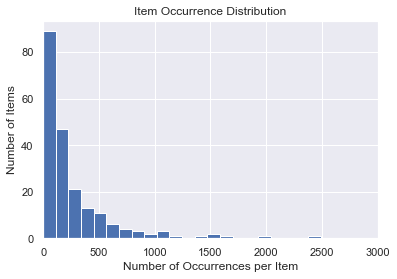

In [45]:
item_occ['count'].plot.hist(title='Item Occurrence Distribution',
                           xlim=[0,3000], bins=50)
plt.xlabel('Number of Occurrences per Item')
plt.ylabel('Number of Items')
plt.savefig('item_occurrence_dist.png')

The highest-occurring normal item has 1132 counts. All other normal items have under 1000 counts.

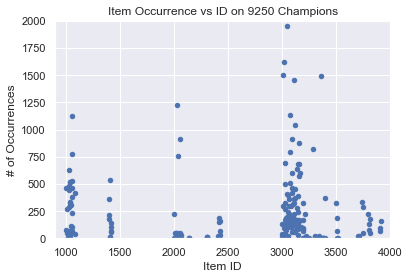

In [46]:
item_occ.reset_index().plot(x='item_id' , y='count', kind='scatter',
                            title='Item Occurrence vs ID on 9250 Champions',
                            xlim=[900, 4000], ylim=[0, 2000])
plt.ylabel('# of Occurrences')
plt.xlabel('Item ID')
plt.savefig('item_occurrence_vs_id.png')

### Pick Rate

This is exactly proportional to counts, just normalized by the number of item slots in the dataframe (7 * 9250).

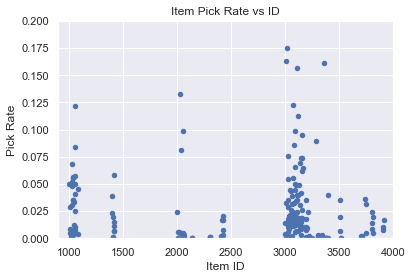

In [47]:
item_occ.reset_index().plot(x='item_id' , y='pick_rate', kind='scatter',
                            title='Item Pick Rate vs ID', xlim=[900, 4000], ylim=[0, 0.2])
#plt.plot(np.linspace(900, 4000, num=50),
#         np.full(50, 6.0/len(items_df[items_df['gold_purchasable'] == True])),
#         'k--')
plt.ylabel('Pick Rate')
plt.xlabel('Item ID')
plt.savefig('item_pick_rate_vs_id.png')

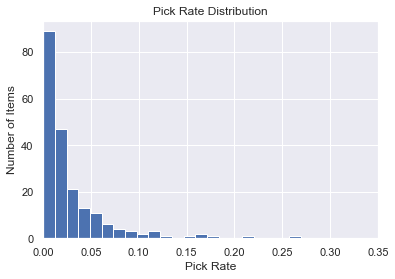

In [48]:
item_occ['pick_rate'].plot.hist(title='Pick Rate Distribution', xlim=[0,0.35], bins=50)
plt.xlabel('Pick Rate')
plt.ylabel('Number of Items')
plt.savefig('item_pick_rate_dist.png')

### Champion Spread

Champion Spread makes sense to correlate with Pick Rate. If more of the 141 champions can viably build an item, then the item should show up more in general.

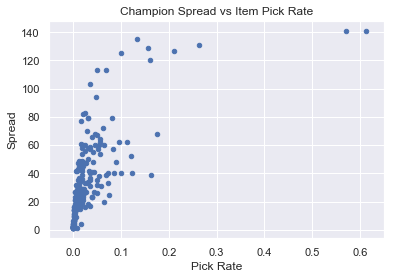

In [49]:
item_occ.reset_index().plot(x='pick_rate', y='spread', kind='scatter',
                            xlim=[-0.05, 0.65], title='Champion Spread vs Item Pick Rate')
plt.xlabel('Pick Rate')
plt.ylabel('Spread')
plt.savefig('champion_spread_vs_pick_rate.png')

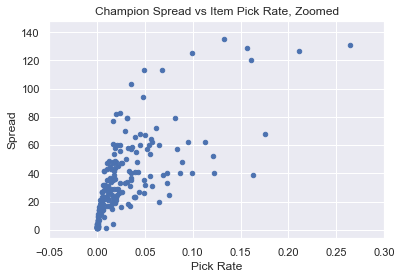

In [50]:
item_occ.reset_index().plot(x='pick_rate', y='spread', kind='scatter',
                            xlim=[-0.05, 0.3], title='Champion Spread vs Item Pick Rate, Zoomed')
plt.xlabel('Pick Rate')
plt.ylabel('Spread')
plt.savefig('champion_spread_vs_pick_rate_zoomed.png')

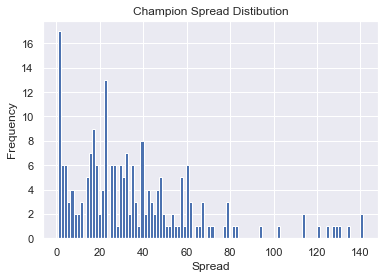

In [51]:
item_occ['spread'].plot.hist(title='Champion Spread Distibution', bins=100)
plt.xlabel('Spread')
plt.savefig('champion_spread_dist.png')

### Win Rate

\# of games with item & win / # of games with item. The true average of actual items should be slightly higher than 50%. The average win rate of the empty item slot (item_id of 0) is about 42%, because players without a full of items tend to lose vs players with full sets of items.

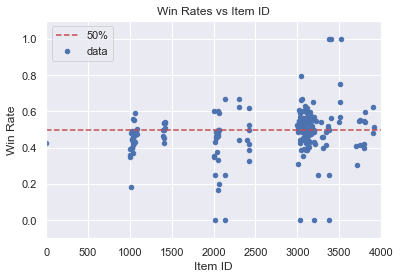

In [52]:
centerline_x = np.linspace(0, 4000, num=50)
centerline_y = np.full(50, 0.5)

item_occ.reset_index().plot(x='item_id', y='win_rate', kind='scatter', xlim=[0, 4000], ylim=[-0.1,1.1], label='data', title='Win Rates vs Item ID')
plt.plot(centerline_x, centerline_y, 'r--', label='50%')
plt.legend(loc=2)
plt.ylabel('Win Rate')
plt.xlabel('Item ID')
plt.savefig('win_rate_vs_item_id.png')

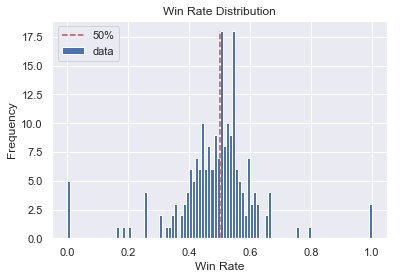

In [53]:
item_occ['win_rate'].plot.hist(title='Win Rate Distribution', bins=100,
                              label='data')
fifty_pct_line_y = np.linspace(0, 18, num = 50)
fifty_pct_line_x = np.full(50, 0.5)
plt.plot(fifty_pct_line_x, fifty_pct_line_y, 'r--', label='50%')
plt.legend(loc=2)
plt.xlabel('Win Rate')
plt.savefig('win_rate_dist.png')

Remove items with fewer than 5 games in the dataframe. This gets rid of all the values at 0 and 1.0

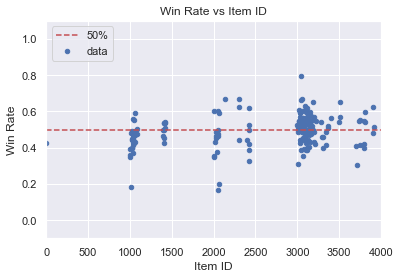

In [54]:
item_occ[item_occ['count'] >= 5].reset_index().plot(x='item_id', y='win_rate', kind='scatter',
                                                  xlim=[0, 4000], ylim=[-0.1,1.1], label='data', title='Win Rate vs Item ID')
plt.plot(centerline_x, centerline_y, 'r--', label='50%')
plt.legend(loc=2)
plt.ylabel('Win Rate')
plt.xlabel('Item ID')
plt.savefig('win_rate_vs_item_id_clipped.png')

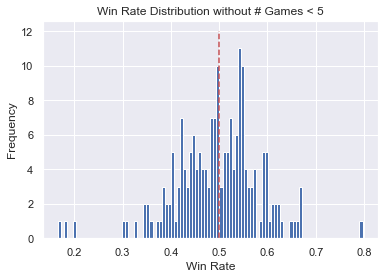

In [55]:
item_occ[item_occ['count'] >= 5]['win_rate'].plot.hist(title='Win Rate Distribution without # Games < 5',
                                                      bins=100, label='data')
fifty_pct_line_y = np.linspace(0, 12, num = 50)
fifty_pct_line_x = np.full(50, 0.5)
plt.plot(fifty_pct_line_x, fifty_pct_line_y, 'r--', label='50%')
plt.xlabel('Win Rate')
plt.savefig('win_rate_dist_clipped.png')

### Pick rate vs win rate

My first guess at a correlation is that items that win more often should get picked more often. However, it seems that items that get picked more often are probably more likely to be picked on both teams in a game, and thus will keep closer to a 50% win rate.

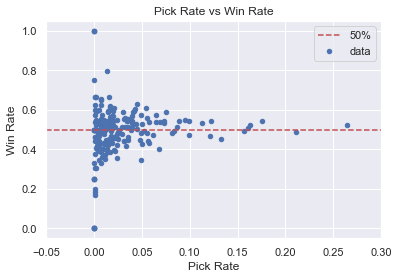

In [56]:
item_occ.plot(x='pick_rate', y='win_rate', kind='scatter', title='Pick Rate vs Win Rate',
             xlim=[-0.05, 0.3], ylim=[-0.05, 1.05], label='data')
plt.plot(np.linspace(-0.05, 0.30, num = 50), np.full(50, 0.5), 'r--', label='50%')
plt.xlabel('Pick Rate')
plt.ylabel('Win Rate')
plt.legend(loc='best')
plt.savefig('pick_rate_vs_win_rate.png')

### Distributions of item costs

The final analysis will probably only include the more expensive items (full items), which are generally located in the right lobe of the distribution.

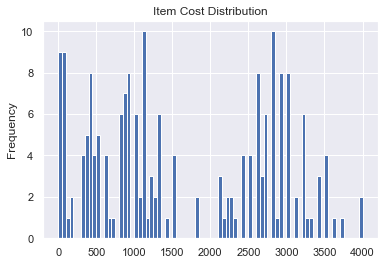

In [57]:
item_occ['total_gold'].plot.hist(title='Item Cost Distribution', bins=80)

I can tell that several of these item costs are for items I don't want to be in my analysis. I will need to have some other cuts to filter them out. I'm guessing they are lane items, boots, potions, etc.

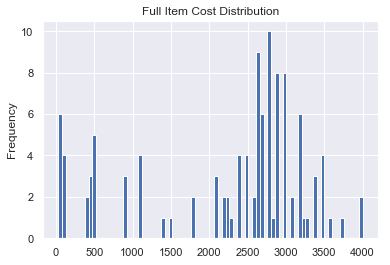

In [58]:
item_occ[(item_occ['full_item'] == True) &
         (item_occ['total_gold'] != 0)]['total_gold'].plot.hist(title='Full Item Cost Distribution', bins=80)

### Pick Rate vs Item Cost

Do more expensive items get picked less often? Not really.

Players generally buy cheaper items more (especially since they build into more items), but this data only includes the last set of items a player had, so it will lean towards the full items that don't get replaced.

The three highest points are the most popular boots. Aside from that, I'm not sure if this is giving me any insights without some information on tags.

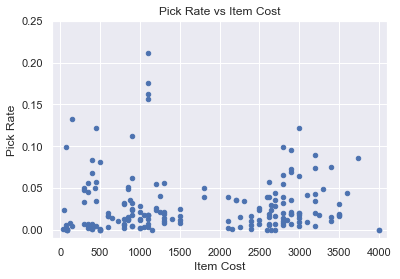

In [59]:
item_occ[(item_occ['total_gold'] != 0)].plot(x='total_gold', y='pick_rate',
                                            title='Pick Rate vs Item Cost', kind='scatter',
                                            xlim=[-100,4100], ylim=[-0.01,0.25])
plt.xlabel('Item Cost')
plt.ylabel('Pick Rate')
plt.savefig('pick_rate_vs_item_cost.png')

### Champion Spread vs Item Cost

This makes sense, as cheaper items generally have more items to build into, so more champions have items they want to build that involve the cheaper items. Note that the Trinkets are not shown here, as they cost 0, but will probably have a maximal value of Spread at 141.

If we take away the left half of this graph, there is much less correlation between item cost and spread, it seems.

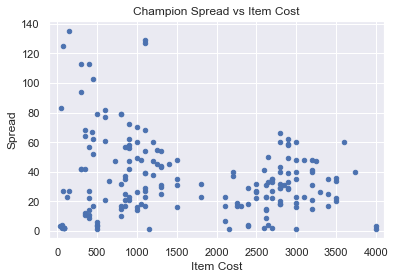

In [60]:
item_occ[(item_occ['total_gold'] != 0)].plot(x='total_gold', y='spread',
                                            title='Champion Spread vs Item Cost', kind='scatter',
                                            xlim=[-100, 4100], ylim=[-5, 142])
plt.xlabel('Item Cost')
plt.ylabel('Spread')
plt.savefig('champion_spread_vs_item_cost.png')

### Win Rate vs Item Cost

This graph shows that the items in the groups of "full item" (on the right) and "not full item" (on the left) have drastically different average win rates. This is because players with incomplete items will probably be weaker than players with complete items, and at a disadvantage.

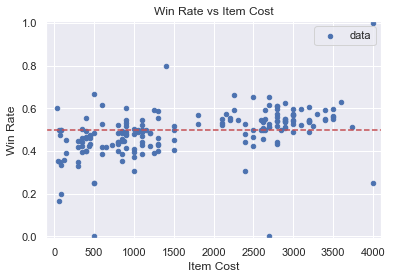

In [61]:
item_occ[(item_occ['total_gold'] != 0)].plot(x='total_gold', y='win_rate',
                                            title='Win Rate vs Item Cost', kind='scatter',
                                            xlim=[-100,4100], ylim=[-0.01,1.01], label='data')
plt.plot(np.linspace(-100, 4100, num = 50),
         np.full(50, 0.5), 'r--', label='50%')
plt.ylabel('Win Rate')
plt.xlabel('Item Cost')
plt.savefig('win_rate_vs_item_cost.png')

## Tag-Based Statistics

Items can be tagged based on the bonuses they give to the champion (health, attack damage, ability power, etc).

Start looking at item tags and break up the previous plots into those groupings.

The items I want to focus on are the main set of full items. Items that are tagged as Consumable, Lane, Boots, and Trinkets will not be included for now. Other items that don't fall into these groups are in the other no nos, and are edge cases.

In [62]:
consumable = [True if (type(tags) == list and 'Consumable' in tags) else False for tags in item_occ['tags']]

lane_items = [True if (type(tags) == list and 'Lane' in tags) else False for tags in item_occ['tags']]

boots = [True if (type(tags) == list and 'Boots' in tags) else False for tags in item_occ['tags']]

trinkets = [True if (type(tags) == list and 'Trinket' in tags) else False for tags in item_occ['tags']]

other_no_no_ids = [2010, 2057, 2403]
other_edge_cases = [True if id in other_no_no_ids else False for id in item_occ.reset_index()['item_id']]

edge_cases = [cons or lane or other or boot or trinket for cons, lane, other, boot, trinket in
              zip(consumable, lane_items, other_edge_cases, boots, trinkets)]
no_edge_cases = [not case for case in edge_cases]

Make the set of tags for items that aren't any of the above.

In [63]:
tag_list = [tag for tags in item_occ[no_edge_cases]['tags'] if type(tags) != float for tag in tags]
tag_list = set(tag_list)
tag_list.remove('Bilgewater')
tag_list

{u'Active',
 u'Armor',
 u'ArmorPenetration',
 u'AttackSpeed',
 u'Aura',
 u'CooldownReduction',
 u'CriticalStrike',
 u'Damage',
 u'GoldPer',
 u'Health',
 u'HealthRegen',
 u'Jungle',
 u'LifeSteal',
 u'MagicPenetration',
 u'Mana',
 u'ManaRegen',
 u'NonbootsMovement',
 u'OnHit',
 u'Slow',
 u'SpellBlock',
 u'SpellDamage',
 u'SpellVamp',
 u'Vision'}

This function takes a table and a tag and gives the entries that include the given tag.

Below is the table for all items with the Damage tag.

In [64]:
def get_items_of_tag(df, tag):
    if (tag not in tag_list):
        raise ValueError('Could not find ' + tag + ' in the tag list')
    given_tag_list = []
    for tags in df['tags']:
        found_tag = True if type(tags) != float and tag in tags else False
        given_tag_list.append(found_tag)
    return df[given_tag_list]

In [65]:
test_fn_df = get_items_of_tag(item_occ, 'Damage').sort_values('win_rate', ascending=False)
test_fn_df

,count,pick_rate,spread,wins,win_rate,name,full_item,total_gold,tags
item_id,,,,,,,,,
2140,6,0.000649,6,4.0,0.666667,Elixir of Wrath,True,500.0,"[Consumable, Damage, LifeSteal, SpellVamp]"
3026,503,0.054378,60,307.0,0.610338,Guardian Angel,True,2800.0,"[Armor, Damage]"
3053,399,0.043135,41,241.0,0.604010,Sterak's Gage,True,3200.0,"[Health, Damage]"
3812,177,0.019135,36,106.0,0.598870,Death's Dance,True,3500.0,"[Damage, LifeSteal, CooldownReduction]"
3036,136,0.014703,29,81.0,0.595588,Lord Dominik's Regards,True,2800.0,"[Damage, ArmorPenetration]"
3031,697,0.075351,25,412.0,0.591105,Infinity Edge,True,3400.0,"[CriticalStrike, Damage]"
3124,456,0.049297,26,261.0,0.572368,Guinsoo's Rageblade,True,3300.0,"[Damage, AttackSpeed, SpellDamage, OnHit]"
3033,77,0.008324,32,44.0,0.571429,Mortal Reminder,True,2800.0,"[ArmorPenetration, Damage]"
3508,185,0.020000,23,105.0,0.567568,Essence Reaver,True,3000.0,"[Damage, AttackSpeed, Mana, ManaRegen, Cooldow..."


Most of the complete items have win rates higher than 50%. This makes sense, because players with incomplete items at the end of the game are more likely to be behind, and thus lose.

## Tag-Based Statistics Table

With the function above, I loop over all the tags found in full items and compute descriptive statistics for each tag. I should consider computing stds.

In [66]:
tag_based_stats_df = pd.DataFrame()
for idx, tag in enumerate(tag_list):
    tag_df = get_items_of_tag(item_occ[no_edge_cases], tag)
    tag_based_stats_df.loc[idx, 'tag'] = tag
    tag_based_stats_df.loc[idx, 'pick_count'] = tag_df['count'].sum()
    tag_based_stats_df.loc[idx, 'avg_pick_rate'] = (tag_df['pick_rate'] * tag_df['count']).sum() / tag_df['count'].sum()
    #tag_based_stats_df.loc[idx, 'std_pick_rate'] = tag_df['pick_rate'].std()
    tag_based_stats_df.loc[idx, 'avg_win_rate'] = (tag_df['win_rate'] * tag_df['count']).sum() / tag_df['count'].sum()
    #tag_based_stats_df.loc[idx, 'std_win_rate'] = tag_df['win_rate'].std()
    tag_based_stats_df.loc[idx, 'avg_champ_spread'] = tag_df['spread'].mean()
    tag_based_stats_df.loc[idx, 'avg_item_cost'] = tag_df['total_gold'].mean()

In [67]:
tag_based_stats_df.sort_values('avg_win_rate', ascending=False)

,tag,pick_count,avg_pick_rate,avg_win_rate,avg_champ_spread,avg_item_cost
12,MagicPenetration,1171.0,0.044507,0.564475,38.800000,2830.000000
16,Aura,896.0,0.022645,0.560268,25.833333,2500.000000
13,CriticalStrike,3375.0,0.064845,0.550519,25.750000,2375.000000
18,Vision,679.0,0.073405,0.541973,33.000000,2900.000000
17,SpellDamage,9634.0,0.047188,0.538821,34.756757,2194.189189
19,ArmorPenetration,2981.0,0.080383,0.536397,25.400000,2430.000000
3,Damage,11421.0,0.060422,0.534629,32.972973,2451.567568
15,Mana,4296.0,0.046418,0.532821,25.750000,2282.625000
14,OnHit,8317.0,0.070238,0.532644,25.307692,2441.653846
2,Armor,5382.0,0.040696,0.532516,41.666667,2068.750000


In [68]:
tag_based_stats_df.to_csv('..\\data\\tag_based_stats_8.22.1.csv', encoding='utf-8')

### Win Rate vs Tag

This shows that Magic Penetration items have the highest average win rate, and Jungle items have the lowest average win rate.

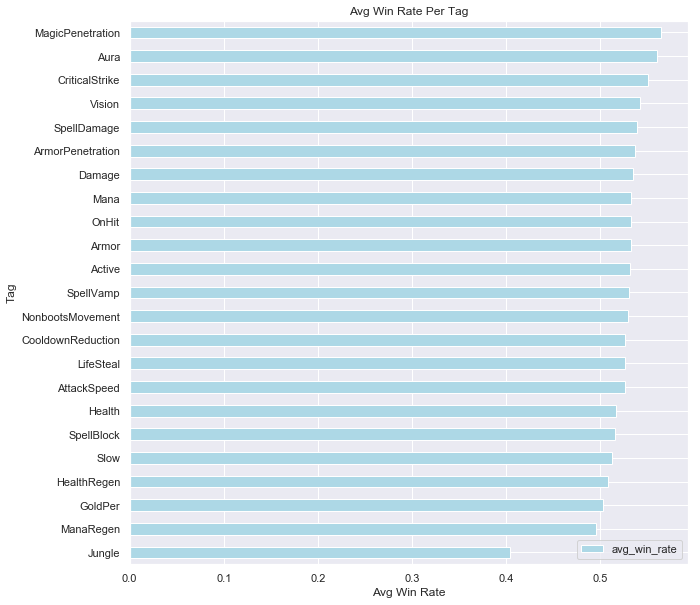

In [69]:
tag_based_stats_df.sort_values('avg_win_rate').plot(x='tag', y='avg_win_rate', kind='barh', figsize=(10,10),
                        color='lightblue', title='Avg Win Rate Per Tag')
plt.ylabel('Tag')
plt.xlabel('Avg Win Rate')
plt.savefig('avg_win_rate_per_tag.png')

### Pick Rate vs Tag

Armor Penetration Items are picked the most often of any tag, which is surprising. I guess that marksmen, assassins, and fighters can all build some sort of armor pen item. Maybe that makes sense.

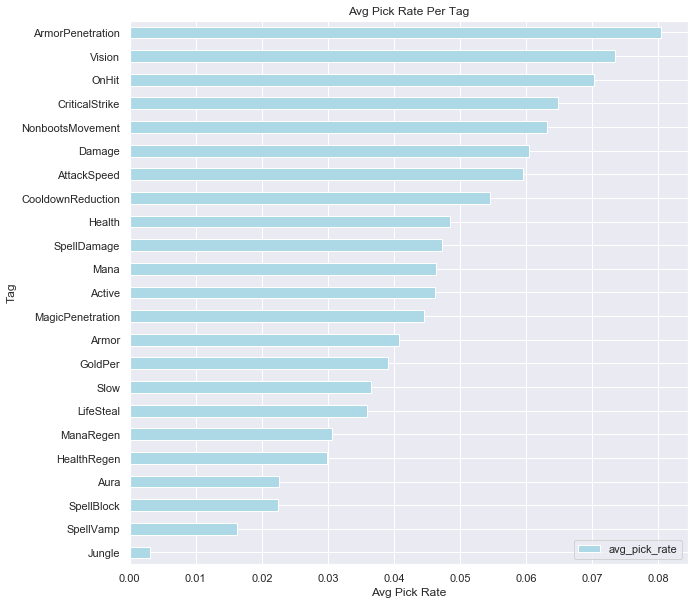

In [70]:
tag_based_stats_df.sort_values('avg_pick_rate').plot(x='tag', y='avg_pick_rate', kind='barh', figsize=(10,10),
                        color='lightblue', title='Avg Pick Rate Per Tag')
plt.ylabel('Tag')
plt.xlabel('Avg Pick Rate')
plt.savefig('avg_pick_rate_per_tag.png')

### Avg Win Rate vs Avg Item Cost for each Tag

It seems like the tags with more expensive items tend to win more often.

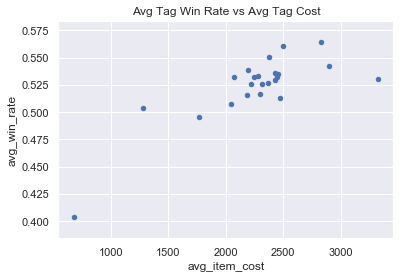

In [71]:
tag_based_stats_df.plot(y='avg_win_rate', x='avg_item_cost', kind='scatter', title='Avg Tag Win Rate vs Avg Tag Cost')

### Avg Pick Rate vs Avg Item Cost for each Tag

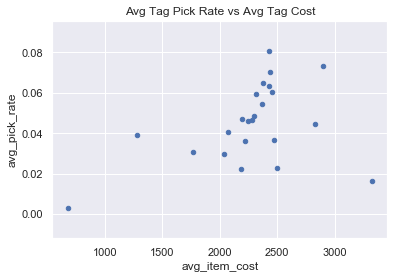

In [72]:
tag_based_stats_df.plot(y='avg_pick_rate', x='avg_item_cost', kind='scatter', title='Avg Tag Pick Rate vs Avg Tag Cost')

### Avg Win Rate vs Avg Pick Rate for each Tag

These values seem to converge as avg pick rate increases.

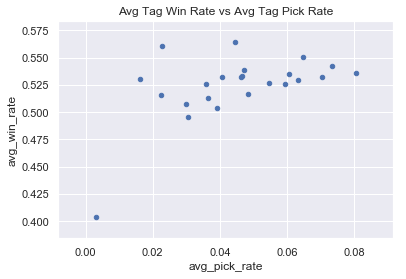

In [73]:
tag_based_stats_df.plot(y='avg_win_rate', x='avg_pick_rate', kind='scatter', title='Avg Tag Win Rate vs Avg Tag Pick Rate')

### Avg Champion Spread vs Avg Pick Rate for each Tag

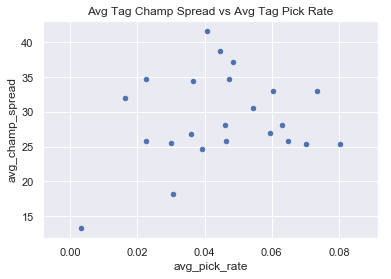

In [74]:
tag_based_stats_df.plot(y='avg_champ_spread', x='avg_pick_rate', kind='scatter',
                        title='Avg Tag Champ Spread vs Avg Tag Pick Rate')

# Build a timing dataframe

Make a dataframe that has individual game data, but one item with its purchase time per row. With NaN values (in purchase_time) there are 64750 rows. After dropna(), there are 52890. This allows me to see when each item was purchased and whether or not the player won with it. This can be used to see if certain items perform better early or late in the game.

Should I put it what item # it is? Does this change if you swap inventory slots, or is it time-ordered?

In [75]:
item_cols = ['stats.item0', 'stats.item1', 'stats.item2', 'stats.item3', 'stats.item4', 'stats.item5', 'stats.item6']
timing_cols = ['item0_time', 'item1_time', 'item2_time', 'item3_time', 'item4_time', 'item5_time', 'item6_time']

timing_df_list = []
for (item, time) in zip(item_cols, timing_cols):
    sub_df = matches_df[[item, time, 'stats.win']]
    sub_df.columns = ['item_id', 'purchase_time', 'win']
    timing_df_list.append(sub_df)

timing_df = pd.concat(timing_df_list).dropna().reset_index(drop=True)
timing_df = timing_df.set_index('item_id').join(items_df[['name', 'full_item', 'total_gold', 'tags']]).reset_index()
timing_df.sort_values('purchase_time').head()

,item_id,purchase_time,win,name,full_item,total_gold,tags
7357,1056,1793.0,False,Doran's Ring,True,400.0,"[Health, Lane, ManaRegen, SpellDamage]"
7992,1056,2001.0,True,Doran's Ring,True,400.0,"[Health, Lane, ManaRegen, SpellDamage]"
8067,1056,2125.0,True,Doran's Ring,True,400.0,"[Health, Lane, ManaRegen, SpellDamage]"
7894,1056,2185.0,False,Doran's Ring,True,400.0,"[Health, Lane, ManaRegen, SpellDamage]"
7740,1056,2241.0,True,Doran's Ring,True,400.0,"[Health, Lane, ManaRegen, SpellDamage]"


In [76]:
timing_df.to_csv('..\\data\\item_timing_8.22.1.csv', encoding='utf-8')

### Item Purchase Time Distribution

This is the overall distribution of purchase times for items that were in a player's inventory when the game ended. If I built the data for all items purchased (and then sold, or overwritten), I would expect more data, especially in the earlier regions of the graph.

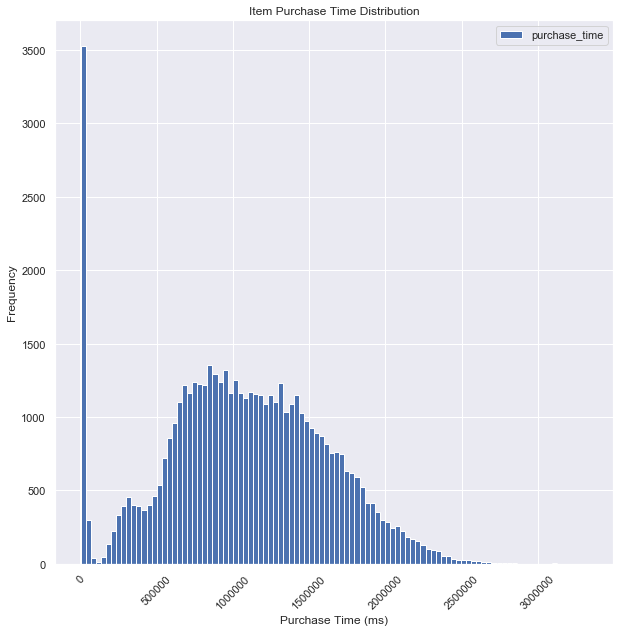

In [77]:
timing_df.plot(y='purchase_time', kind='hist', rot=45, figsize=(10,10), bins=100,
              title='Item Purchase Time Distribution')
plt.xlabel('Purchase Time (ms)')
plt.savefig('item_purchase_time_dist.png')

### Sample Win Rate vs Purchase Time for the item Stormrazor's Surge

It seems like this item perform better when purchased later in the game.

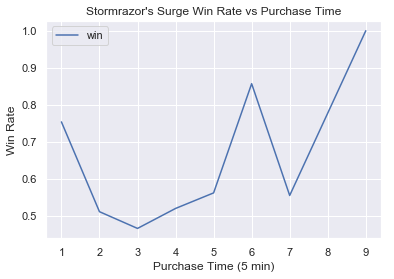

In [78]:
timing_df[timing_df['name'] == 'Stormrazor'].groupby(timing_df['purchase_time'] // 300000).mean().plot(y='win')
plt.title('Stormrazor\'s Surge Win Rate vs Purchase Time')
plt.xlabel('Purchase Time (5 min)')
plt.ylabel('Win Rate')
plt.savefig('stormrazor_win_rate_vs_purchase_time.png')

purchase time ranges from 1793.0 to 3,328,290.0

In [79]:
tag_labeled_df_list = []

for tag in tag_list:
    timing_tags_df = get_items_of_tag(timing_df, tag)
    timing_tags_df['tag'] = tag
    tag_labeled_df_list.append(timing_tags_df)
#timing_tags_df[timing_tags_df['win'] == True].plot(y='purchase_time', kind='hist', bins=100, ylim=[0,1000])
tag_labeled_df = pd.concat(tag_labeled_df_list)
tag_labeled_df.head()

C:\Users\sebia\Miniconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,item_id,purchase_time,win,name,full_item,total_gold,tags,tag
14038,2065,1015088.0,True,Shurelya's Reverie,True,2250.0,"[Health, SpellDamage, ManaRegen, Active, Coold...",CooldownReduction
14039,2065,1745323.0,True,Shurelya's Reverie,True,2250.0,"[Health, SpellDamage, ManaRegen, Active, Coold...",CooldownReduction
14040,2065,1220367.0,False,Shurelya's Reverie,True,2250.0,"[Health, SpellDamage, ManaRegen, Active, Coold...",CooldownReduction
14041,2065,1604704.0,True,Shurelya's Reverie,True,2250.0,"[Health, SpellDamage, ManaRegen, Active, Coold...",CooldownReduction
14042,2065,1610208.0,False,Shurelya's Reverie,True,2250.0,"[Health, SpellDamage, ManaRegen, Active, Coold...",CooldownReduction


In [80]:
#timing_tags_df.boxplot(column='purchase_time', by='win')

Plot win rate every 5 min? distinguish specific items?

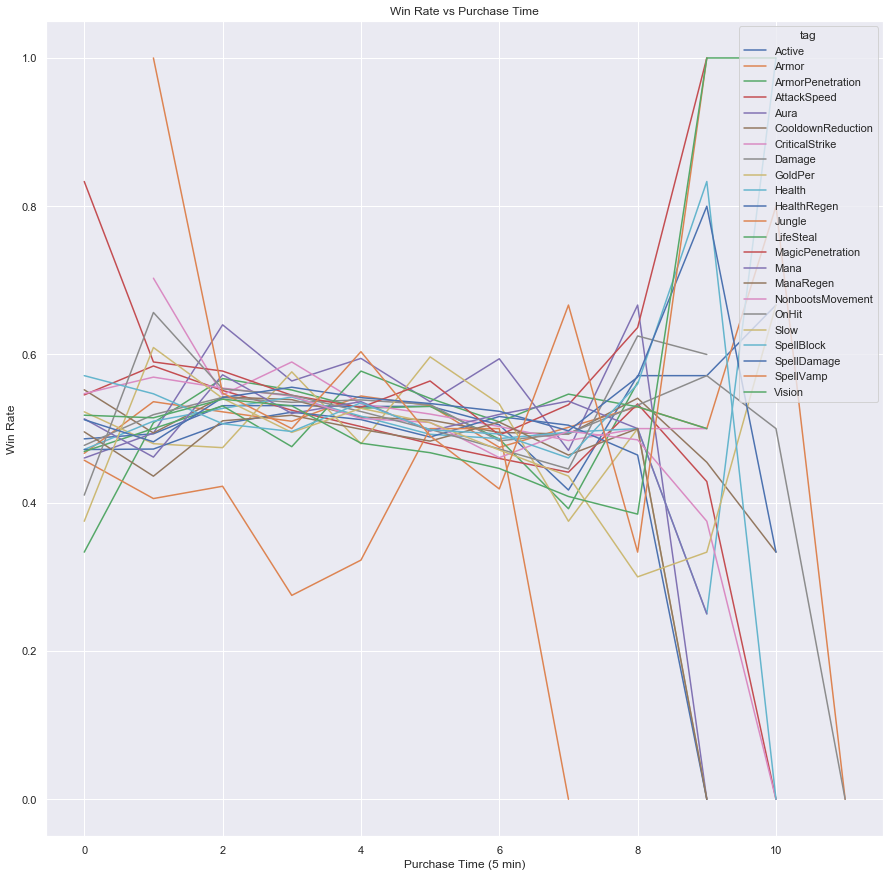

In [81]:
tag_based_time_win_rates = tag_labeled_df.groupby([tag_labeled_df['purchase_time'] // 300000, 'tag']
                                                 ).mean().unstack('tag')[['win']]
tag_based_time_win_rates.plot(y='win', title='Win Rate vs Purchase Time', figsize=(15,15))
plt.xlabel('Purchase Time (5 min)')
plt.ylabel('Win Rate')
plt.show()

This plot is not useful. But it is funny.

### Summary

I have visualized pick rate, win rate, champion spread, and item costs. I have looked at some correlations between these, and examined statistics based on specific kinds / tags of items. 

Pick rate and win rate are the most important statistics. Tag-based statistics are too complicated for now, and I'm not sure what to do with them. Timing data seems very useful, but I am also unsure how I will use that.